In [72]:
import os
import re
import json
import socket
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import utils as pu
from pyspark.sql import functions as F
from pyspark.sql import types as pt

## Assignment #1 

This task rely on to 

In [73]:
print('user:', os.environ['JUPYTERHUB_SERVICE_PREFIX'])

def uiWebUrl(self):
    from urllib.parse import urlparse
    web_url = self._jsc.sc().uiWebUrl().get()
    port = urlparse(web_url).port
    return '{}proxy/{}/jobs/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)

SparkContext.uiWebUrl = property(uiWebUrl)

conf = SparkConf().set('spark.master', 'local[*]').set('spark.driver.memory', '4g').set("spark.executor.instances", "4")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

user: /user/st051999/


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at /tmp/ipykernel_58/3605542823.py:12 

## Songs 

The songs. Note that data is in unicode.

- song_id
- song_length: in ms
- genre_ids: genre category. Some songs have multiple genres and they are separated by |
- artist_name
- composer
- lyricist
- language


In [74]:
songs = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/songs.csv")

songs.limit(100).toPandas().head(10)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,None,None,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17.0
6,N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=,226220,458,伍佰 & China Blue,Jonathan Lee,None,3.0
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,276793,465,光良 (Michael Wong),光良,彭資閔,3.0
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,228623,465,林俊傑 (JJ Lin),JJ Lin,Wu Qing Feng,3.0
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,52.0


## "Train" data

Some data of users listen history 

- msno: user id
- song_id: song id
- source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
- source_screen_name: name of the layout a user sees.
- source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
- target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .


In [75]:
listen_history = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/train.csv")

listen_history.show()

+--------------------+--------------------+-----------------+-------------------+-------------------+------+
|                msno|             song_id|source_system_tab| source_screen_name|        source_type|target|
+--------------------+--------------------+-----------------+-------------------+-------------------+------+
|FGtllVqz18RPiwJj/...|BBzumQNXUHKdEBOB7...|          explore|            Explore|    online-playlist|     1|
|Xumu+NIjS6QYVxDS4...|bhp/MpSNoqoxOIB+/...|       my library|Local playlist more|     local-playlist|     1|
|Xumu+NIjS6QYVxDS4...|JNWfrrC7zNN7BdMps...|       my library|Local playlist more|     local-playlist|     1|
|Xumu+NIjS6QYVxDS4...|2A87tzfnJTSWqD7gI...|       my library|Local playlist more|     local-playlist|     1|
|FGtllVqz18RPiwJj/...|3qm6XTZ6MOCU11x8F...|          explore|            Explore|    online-playlist|     1|
|FGtllVqz18RPiwJj/...|3Hg5kugV1S0wzEVLA...|          explore|            Explore|    online-playlist|     1|
|Xumu+NIjS6QYVxDS4.

## Assignment:

PREFER DATA FRAME API(!)

Vision of result:
- self-sufficient jupyter notebook
- not only the code but n
- published on github 
- link to your github attached here https://docs.google.com/spreadsheets/d/1F8ScpCCiBaxiyZqDd09jn6t25pykiK8oauJbRuuA8Q4/edit?usp=sharing


Task 1: 
- Find out top-20 of most popular artist's in terms of: raw listens, unique users listens;

Task 2: 
- find out top-3 languages by num of raw listens
- build histogram of songs length by language / genre. What is the longest genre? What is more valuable in terms of length: language or genre? 

Deadlines:
- soft 17.05
- hard 24.05

#### Task 1

Find out top-20 of most popular artist's in terms of: raw listens, unique users listens

In [76]:
songs = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/malyutin_temp/kkbox-music-recommendation-challenge/song_extra_info.csv")

songs.limit(100).toPandas().head(10)

AnalysisException: Path does not exist: file:/home/jovyan/malyutin_temp/kkbox-music-recommendation-challenge/song_extra_info.csv

The path does not exist

In [77]:
#creates a local temporary view with this dataframe df. Lifetime of this view is dependent to SparkSession class
listen_history.createOrReplaceTempView("listen_history")
songs.createOrReplaceTempView("songs")

In [78]:
# SQL-query select artist, number of raw liistners, number of unique listeners
spark.sql("""
SELECT songs.artist_name as artist, count(msno) as raw_listeners
FROM listen_history JOIN songs ON listen_history.song_id = songs.song_id
GROUP BY artist
ORDER BY raw_listeners desc
""").toPandas().head(20)

,artist,raw_listeners
0,Various Artists,303617
1,周杰倫 (Jay Chou),186776
2,五月天 (Mayday),182088
3,林俊傑 (JJ Lin),115325
4,田馥甄 (Hebe),104946
5,aMEI (張惠妹),82799
6,陳奕迅 (Eason Chan),76035
7,玖壹壹,70445
8,G.E.M.鄧紫棋,67297
9,BIGBANG,61927


In [79]:
# SQL-query select artist, number of raw liistners, number of unique listeners, in descending order
spark.sql("""
SELECT songs.artist_name as artist, count(DISTINCT msno) as unique_listeners
FROM listen_history JOIN songs ON listen_history.song_id = songs.song_id
GROUP BY artist
ORDER BY unique_listeners desc
""").toPandas().head(20)

,artist,unique_listeners
0,Various Artists,22256
1,田馥甄 (Hebe),18771
2,周杰倫 (Jay Chou),18727
3,五月天 (Mayday),18183
4,林俊傑 (JJ Lin),17160
5,陳奕迅 (Eason Chan),16290
6,G.E.M.鄧紫棋,16064
7,Eric 周興哲,15672
8,謝和弦 (R-chord),15313
9,aMEI (張惠妹),15169


#### Task 2:

* find out top-3 languages by num of raw listens 

* build histogram of songs length by language / genre. What is the longest genre? What is more valuable in terms of length: language or genre?

In [82]:
# SQL-query select language, number of raw liistners in descending order
spark.sql("""
SELECT songs.language as language, count(msno) as raw_listeners
FROM listen_history JOIN songs ON listen_history.song_id = songs.song_id
GROUP BY language
ORDER BY raw_listeners desc
""").toPandas().head(3)

,language,raw_listeners
0,3.0,4044643
1,52.0,1864788
2,31.0,656623


In [83]:
# SQL-query select language, length in descending order
language_histogram = spark.sql("""
SELECT language, sum(song_length) as sum_songs_length_ms
FROM songs
GROUP BY language
ORDER BY sum_songs_length_ms desc
""").toPandas()
language_histogram.head()

,language,sum_songs_length_ms
0,52.0,3.134235e+11
1,-1.0,1.764514e+11
2,3.0,2.594856e+10
3,17.0,2.316844e+10
4,24.0,9.963970e+09


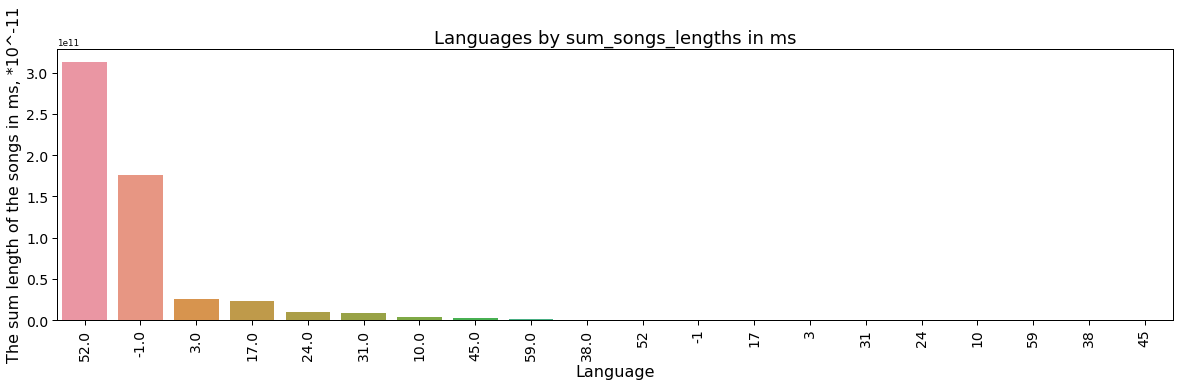

In [84]:
# Create a barchart for language 
fig, ax = plt.subplots(figsize=(20, 5))

sns.barplot(x='language', y='sum_songs_length_ms', data=language_histogram, ax=ax)
ax.set_title("Languages by sum_songs_lengths in ms", fontsize=18) 

plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Language', fontsize=16);
plt.ylabel('The sum length of the songs in ms, *10^-11', fontsize=16)
plt.xticks(rotation=90)
plt.show()

In [91]:
# SQL-query select genre, length and for multiple-genres songs count in descending order
genre_histogram = spark.sql("""
SELECT genre_ids, sum(song_length) as sum_songs_length_ms, count(song_length) as count_appearance
FROM songs
GROUP BY genre_ids
ORDER BY sum_songs_length_ms desc
""").toPandas()
genre_histogram.head()

,genre_ids,sum_songs_length_ms,count_appearance
0,465,1.331078e+11,568019
1,958,5.268465e+10,176397
2,1609,4.841611e+10,166492
3,2022,4.098127e+10,168908
4,2122,3.549514e+10,139972


In [92]:
genre_histogram = genre_histogram[~genre_histogram['genre_ids'].isna()]

In [93]:
genres = dict()
for i in genre_histogram.itertuples():
    if '|' in i[1]:
        for j in i[1].split('|'):
            if j in genres.keys():
                genres[j] = [genres[j][0] + i[2], genres[j][1] + i[3]]
            else:
                genres[j] = [i[2], i[3]]
    else:
        if i[1] in genres.keys():
            genres[i[1]] = [genres[i[1]][0] + i[2], genres[i[1]][1] + i[3]]
        else:
            genres[i[1]] = [i[2], i[3]]

In [94]:
# df with dictionary genres
df_genres = pd.DataFrame()
df_genres['genre'] = genres.keys()
df_genres['combined'] = genres.values()
df_genres = df_genres.combined.apply(pd.Series) \
    .merge(df_genres, left_index = True, right_index = True) \
    .drop(["combined"], axis = 1) \
    .rename(columns={0: "sum_songs_length_ms", 1: "count_appearance"})

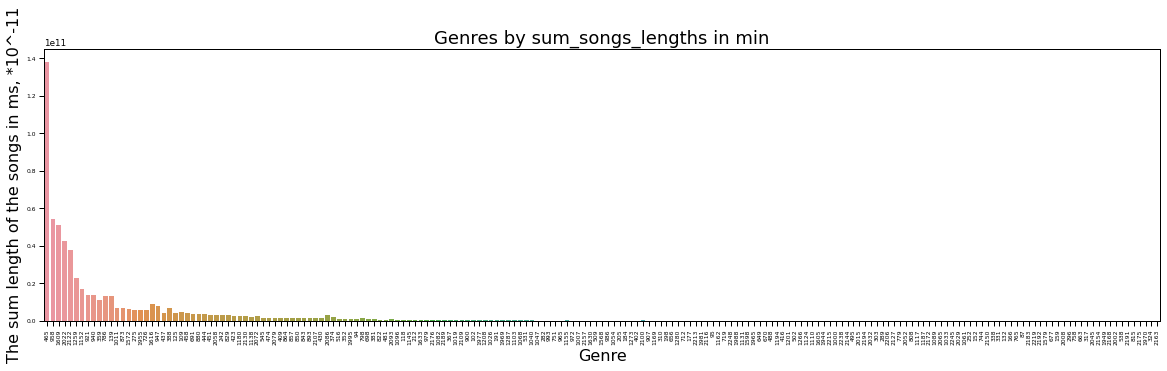

In [95]:
# Create a barchart for genres
fig, ax = plt.subplots(figsize=(20, 5))

sns.barplot(x='genre', y='sum_songs_length_ms', data=df_genres, ax=ax)
ax.set_title("Genres by sum_songs_lengths in min", fontsize=18) 

plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Genre', fontsize=16);
plt.ylabel('The sum length of the songs in ms, *10^-11', fontsize=16)
plt.xticks(rotation=90)
plt.show()

Answering the question.
More valuable than the genre. On the genre graph, we see one dominant (blues, most likely), then a group of 4 genres, then 7 genres, and so we can divide the rest into groups. Thus, we can identify certain groups of genres and analyze this information
While in languages we can see two dominants, and other languages.